knn

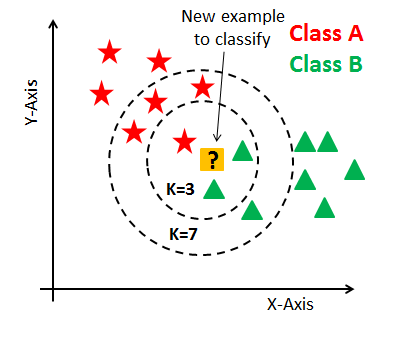

lightgbm

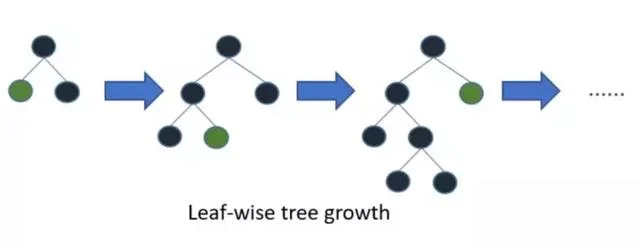

Other boosting algorithm

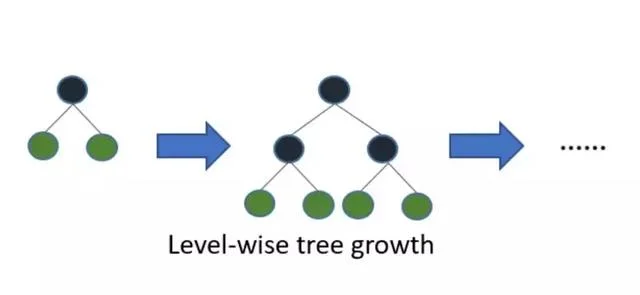

voting classifier

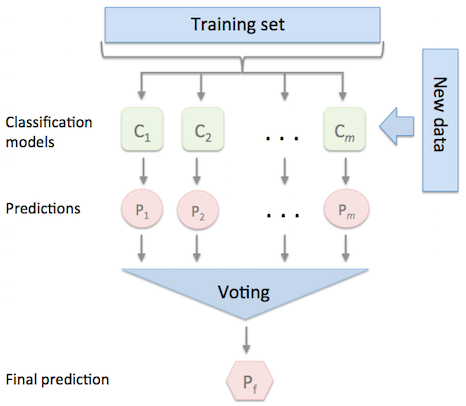

# <a id='1'>1. Load libraries and read the data</a> 

## <a id='1.1'>1.1. Load libraries</a> 

Loading the libraries

In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd # linear algebra
import numpy as np # data processing, CSV file I/O

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import cross_val_predict

# Tensorflow 
import tensorflow as tf

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform



#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

## <a id='1.2'>1.2. Read data</a> 

Loading dataset with pandas (pd)

In [2]:
data = pd.read_csv('diabetes.csv')

## <a id='2'>2. Data Preprocessing</a> 

## <a id='2.1'>2.1. Data Preprocessing</a> 

find the median for filling null values

In [ ]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
data.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [3]:
## As seen earlier there is no null value. However on close inspection we find that null values are filled with '0'

data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].replace(0,np.NaN)    

In [4]:
## Checking the new null values found.
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [5]:
## to find the median for filling null values

def find_median(var):
    temp = data[data[var].notnull()]
    temp = data[[var,'Outcome']].groupby('Outcome')[[var]].median().reset_index()
    return temp

In [6]:
# Now we will be filling these values instead of null values
print(find_median('Insulin'))

data.loc[(data['Outcome'] == 0) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1) & (data['Insulin'].isnull()), 'Insulin'] = 169.5
print(find_median('SkinThickness'))

data.loc[(data['Outcome'] == 0) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27.0
data.loc[(data['Outcome'] == 1) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32.0

print(find_median('BloodPressure'))
data.loc[(data['Outcome'] == 0) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70.0
data.loc[(data['Outcome'] == 1) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

print(find_median('BMI'))
data.loc[(data['Outcome'] == 0) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1) & (data['BMI'].isnull()), 'BMI'] = 34.3

print(find_median('Glucose'))
data.loc[(data['Outcome'] == 0) & (data['Glucose'].isnull()) , 'Glucose'] = 107.0
data.loc[(data['Outcome'] == 1) & (data['Glucose'].isnull()) , 'Glucose'] = 140.0

   Outcome  Insulin
0        0    102.5
1        1    169.5
   Outcome  SkinThickness
0        0           27.0
1        1           32.0
   Outcome  BloodPressure
0        0           70.0
1        1           74.5
   Outcome   BMI
0        0  30.1
1        1  34.3
   Outcome  Glucose
0        0    107.0
1        1    140.0


In [7]:
datanames = data.columns
print("資料欄位名稱：" ,datanames)

data = data.to_numpy()
print("\n資料維度：", data.shape)

資料欄位名稱： Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

資料維度： (768, 9)


In [8]:
import numpy as np
from collections import Counter

featurenames = datanames[0:8]
print("特徵名稱：" ,featurenames)

feature = np.delete(data, 8, axis=1) 
label = data[:,8]

print("\n資料集類別數量：%s" %Counter(label))

特徵名稱： Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

資料集類別數量：Counter({0.0: 500, 1.0: 268})


In [9]:
from sklearn.model_selection import train_test_split 

train_x, test_x, train_y, test_y = train_test_split(feature, label, random_state = 0, test_size = 0.2)

print("訓練集數量", len(train_x))
print("測試集數量", len(test_x))
print("訓練集類別數量：%s" %Counter(train_y))
print("測試集類別數量：%s" %Counter(test_y))


訓練集數量 614
測試集數量 154
訓練集類別數量：Counter({0.0: 393, 1.0: 221})
測試集類別數量：Counter({0.0: 107, 1.0: 47})


Min-Max Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

## <a id='3'>3. Training and evaluation</a> 

![](http://image.noelshack.com/fichiers/2019/06/1/1549285917-0000000000000000000.png)

** LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

To find the best hyperparameters, we'll use Random Search CV.

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. 
Generally RS is more faster and accurate than GridSearchCV who calculate all possible combinations. With Random Grid we specify the number of combinations that we want

* **LightGBM : Hyperparameters ** :

    * learning_rate : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates
    * n_estimators : number of trees (or rounds)
    * num_leaves : number of leaves in full tree, default: 31
    * min_child_samples : minimal number of data in one leaf. Can be used to deal with over-fitting
    * min_child_weight : minimal sum hessian in one leaf.
    * subsample : randomly select part of data without resampling
    * max_depth : It describes the maximum depth of tree. This parameter is used to handle model overfitting.
    * colsample_bytree : LightGBM will randomly select part of features on each iteration if colsample_bytree smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
    * reg_alpha : regularization
    * reg_lambda : regularization
    
    * early_stopping_rounds : This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations

In [11]:
random_state=42
opt_parameters =  {'colsample_bytree': 0.9188117152201242, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 137, 'min_child_weight': 0.1, 'n_estimators': 200, 'num_leaves': 19, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.38188584007687904}
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

In [12]:
lgbm_clf.fit(train_x,train_y)
y_pred_lgbm = lgbm_clf.predict(test_x)

In [13]:
from sklearn.metrics import accuracy_score
print("lgbm")
print(accuracy_score(test_y, y_pred_lgbm))

lgbm
0.8896103896103896


I obtain a good result but I can close to 90% with adding a KNeighborsClassifier to LightGBM (Voting Classifier)

* **KNeighborsClassifier** : KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, where  k is an integer value specified by the user.

* **VotingClassifier** : VotingClassifier is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting

n_neighbors : int, optional (default = 5)

*   Number of neighbors to use by default for kneighbors queries.

weights : str or callable, optional (default = ‘uniform’)

* weight function used in prediction. Possible values:

* ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
* ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
* [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.


algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional
Algorithm used to compute the nearest neighbors:

* ‘ball_tree’ will use BallTree
* ‘kd_tree’ will use KDTree
* ‘brute’ will use a brute-force search.
* ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

Note: fitting on sparse input will override the setting of this parameter, using brute force.

leaf_size : int, optional (default = 30)

* Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

p : integer, optional (default = 2)

* Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

metric : string or callable, default ‘minkowski’

* the distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric. See the documentation of the DistanceMetric class for a list of available metrics.

metric_params : dict, optional (default = None)

* Additional keyword arguments for the metric function.

n_jobs : int, optional (default = 1)

* The number of parallel jobs to run for neighbors search. If -1, then the number of jobs is set to the number of CPU cores. Doesn’t affect fit method.

In [14]:
knn_clf = KNeighborsClassifier(n_neighbors = 25)

estimatorslist of (str, estimator) tuples
> Invoking the fit method on the VotingClassifier will fit clones of those original estimators that will be stored in the class attribute self.estimators_. An estimator can be set to 'drop' using set_params.


voting{‘hard’, ‘soft’}, default=’hard’
> If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

weightsarray-like of shape (n_classifiers,), default=None
> Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting). Uses uniform weights if None.

n_jobsint, default=None
> The number of jobs to run in parallel for fit. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


flatten_transformbool, default=True
> Affects shape of transform output only when voting=’soft’ If voting=’soft’ and flatten_transform=True, transform method returns matrix with shape (n_samples, n_classifiers * n_classes). If flatten_transform=False, it returns (n_classifiers, n_samples, n_classes).

verbosebool, default=False
> If True, the time elapsed while fitting will be printed as it is completed.

In [15]:
knn_clf.fit(train_x,train_y)
y_pred = knn_clf.predict(test_x)

In [16]:
from sklearn.metrics import accuracy_score
print("knn")
print(accuracy_score(test_y, y_pred))

knn
0.8181818181818182


In [17]:
voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
                     voting='soft', weights = [1,2])

In [18]:
voting_clf.fit(train_x,train_y)
y_p = voting_clf.predict(test_x)

In [19]:
print("voting")
accuracy_score(test_y, y_p)

voting


0.8896103896103896

In [20]:
from sklearn.externals import joblib 
#Storage Model
joblib.dump(knn_clf, 'KNN.pkl')

#Read Model
knn_clf = joblib.load('KNN.pkl')

In [21]:
joblib.dump(lgbm_clf, 'LGBMClassifier.pkl')

lgbm_clf = joblib.load('LGBMClassifier.pkl')

In [22]:

joblib.dump(voting_clf, 'LGBM+KNN.pkl')

voting_clf = joblib.load('LGBM+KNN.pkl')